# Hands-on tutorial on Convnets with Torch

Adapted from [assignment 2](http://cs231n.github.io/assignment2/) and [assignment 3](http://cs231n.github.io/assignment3/) of CS231N (the Convnet course at Stanford)

Pre-requisites:

CS231N: [this part](http://cs231n.github.io/neural-networks-3) and [this part](http://cs231n.github.io/convolutional-networks/)




Math/linear algebra: [tensors](http://www.physlink.com/Education/AskExperts/ae168.cfm) (N-rank generalizations of numbers (0-tensors), vectors (1-tensors) and matrices (2-tensors))

Basics of Torch: [Deep Learning with Torch: the 60-minute blitz](https://github.com/soumith/cvpr2015/blob/master/Deep%20Learning%20with%20Torch.ipynb)


[Install Torch](http://torch.ch/docs/getting-started.html)

# Warm-up exercise: Add two tensors
https://github.com/torch/torch7/blob/master/doc/maths.md#res-torchaddres-tensor1-tensor2

In [4]:
function addTensors(a,b)
    return  a+b -- your code here
end

In [5]:
a = torch.ones(8,2)
b = torch.Tensor(2,8):fill(4)
print(addTensors(a,b))

 5  5
 5  5
 5  5
 5  5
 5  5
 5  5
 5  5
 5  5
[torch.DoubleTensor of size 8x2]



# Load the data
Load up part of CIFAR-10 data, which are 32x32 colored images.

In [6]:
-- os.execute('wget -c https://s3.amazonaws.com/torch7/data/cifar10torchsmall.zip')
-- os.execute('unzip cifar10torchsmall.zip')
trainset = torch.load('cifar10-train.t7')
testset = torch.load('cifar10-test.t7')
classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [7]:
print(trainset)  

{
  data : ByteTensor - size: 10000x3x32x32
  label : ByteTensor - size: 10000
}


# Visualize some images


In [8]:
math.randomseed(os.time())
-- see http://stackoverflow.com/a/20157671

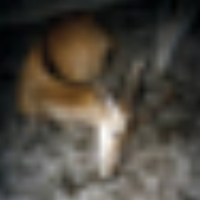

deer	


In [20]:
require 'image'

random_number= math.random(10000) 
img=image.scale(trainset.data[random_number],200 ) -- increase image size 

img=itorch.image(img) -- display the random_number-th image in dataset
print(classes[trainset.label[random_number]])

# Pre-process data


In [21]:
-- ignore setmetatable for now, it is a feature beyond the scope of this tutorial. It sets the index operator.
setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function trainset:size() 
    return self.data:size(1) 
end

In [22]:
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future
for i=1,3 do -- over each image channel
    mean[i] = trainset.data[{ {}, {i}, {}, {}  }]:mean() -- mean estimation
    print('Channel ' .. i .. ', Mean: ' .. mean[i])
    trainset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction
    
    stdv[i] = trainset.data[{ {}, {i}, {}, {}  }]:std() -- std estimation
    print('Channel ' .. i .. ', Standard Deviation: ' .. stdv[i])
    trainset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

Channel 1, Mean: 125.83175029297	


Channel 1, Standard Deviation: 63.143400842609	


Channel 2, Mean: 123.26066621094	


Channel 2, Standard Deviation: 62.369209019002	


Channel 3, Mean: 114.03068681641	


Channel 3, Standard Deviation: 66.965808411114	


# Train a ConvNet!

The architecture is conv-relu-pool-Dense-Logsoftmax, where the conv layer uses stride-1.

Try 20 filters, of size 5x5.
The pool layer uses non-overlapping
  2x2 pooling regions.

Hint: since the input image is a (3,32,32)-tensor, and stride=1, padding=0,then the output of the conv layer is of size: 

(output channels, (32-5)/1+1, (32-5)/1+1 ), see http://cs231n.github.io/convolutional-networks/#conv


In [24]:
require 'nn';

In [31]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(3, 20, 5, 5)) -- 1 input image channel, 6 output channels, 5x5 convolution kernel
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.View(20*14*14))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(20*14*14, 10))             -- fully connected layer (matrix multiplication between input and weights )                -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                


-- your code here

In [32]:
criterion = nn.ClassNLLCriterion()
trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.0001
trainer.maxIteration = 10 -- just do 10 epochs of training.

In [33]:
trainer:train(trainset)

# StochasticGradient: training	


# current error = 1.9361677089258	


# current error = 1.7452883554512	


# current error = 1.658196127829	


# current error = 1.5928728089322	


# current error = 1.5381462881896	


# current error = 1.4913058549898	


# current error = 1.4504505318053	


# current error = 1.4137438937895	


# current error = 1.3797005608154	


# current error = 1.3473396056857	
# StochasticGradient: you have reached the maximum number of iterations	
# training error = 1.3473396056857	



###Questions: 
###1. why the output layer is LogSoftmax, and not Softmax?
###2. for the criterion, why do we minimize the cross entropy? instead of, for example, maximizing accuracy?

(your answers here)

In [ ]:
net:zeroGradParameters() -- zero the internal gradient buffers of the network 

Let's look at the performance of this model.

Let's take an image at random and see if it classifies it correctly

In [34]:
testset.data = testset.data:double()   -- convert from Byte tensor to Double tensor
for i=1,3 do -- over each image channel
    testset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction    
    testset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

Predictions of the model:	


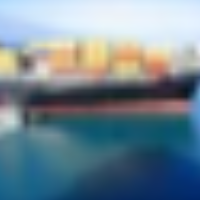

airplane	37 %	


automobile	0 %	


bird	0 %	


cat	0 %	


deer	0 %	


dog	0 %	


frog	0 %	


horse	0 %	


ship	57 %	


truck	1 %	
Answer: ship	


In [36]:

random_number= math.random(10000) 
img=image.scale(testset.data[random_number],200 ) -- increase image size 

img=itorch.image(img) -- display the random_number-th image in dataset

print('Predictions of the model:')
for i=1,#classes do
    print(classes[i], math.floor(100*net:forward(testset.data[random_number]):exp()[i]) .. ' %'  )
end

--print(net:forward(testset.data[random_number]):exp()    )
print( 'Answer: ' .. classes[testset.label[random_number]])

Compute the error on the test set.

Hint: https://github.com/torch/nn/blob/master/doc/training.md#nn.traningneuralnet.dok

If your computer crashes, use a smaller test set with the operation 'narrow':
https://github.com/torch/torch7/blob/master/doc/tensor.md

In [83]:
N = 10000
test_set_small_data = testset.data:narrow(1, 1, N)
erro = 0

for nubr = 1,N do
    nrt_pob = net:forward(testset.data[nubr]):exp()
    pred, index =  torch.max(nrt_pob)
    max_class_id = nil
    for class_id =1,10 do
        if nrt_pob[class_id] == pred then
            max_class_id = class_id
        end
    end
    if max_class_id ==  testset.label[nubr] then
        erro =  erro + 1
    end
end     
print("Error")
print(erro/N)

Error	
0.4825	


Alright, fine. Some examples sucked, but how many in total seem to be correct over the test set?

In [84]:
correct = 0
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end

In [85]:
print( 100*correct/10000 .. ' % ')

48.25 % 	


That should look waaay better than chance, which is 10% accuracy (randomly picking a class out of 10 classes), if the network learnt something (and if you learnt something too, btw).

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [86]:
class_performance = {0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        class_performance[groundtruth] = class_performance[groundtruth] + 1
    end
end

In [87]:
for i=1,#classes do
    print(classes[i], 100*class_performance[i]/1000 .. ' %')
end

airplane	50.7 %	
automobile	60.4 %	
bird	38.2 %	
cat	29.3 %	
deer	40.9 %	
dog	40 %	
frog	57.8 %	
horse	51.4 %	
ship	61.4 %	
truck	52.4 %	


#Dropout

To reduce overfitting, we can use dropout. See what happens!

See: http://torch.ch/blog/2015/07/30/cifar.html

In [88]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(3, 20, 5, 5)) -- 1 input image channel, 6 output channels, 5x5 convolution kernel
net:add(nn.Dropout(0.3))
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.Dropout(0.3))
net:add(nn.View(20*14*14))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(20*14*14, 10))             -- fully connected layer (matrix multiplication between input and weights )                -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                


-- your code here

In [90]:
criterion = nn.ClassNLLCriterion()
trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.0001
trainer.maxIteration = 10 -- just do 10 epochs of training.

In [91]:
trainer:train(trainset)

# StochasticGradient: training	


# current error = 1.9350715543268	


# current error = 1.7007494927242	


# current error = 1.583206922405	


# current error = 1.499919139781	


# current error = 1.4355628368086	


# current error = 1.379415290672	


# current error = 1.3450310969558	


# current error = 1.3145561510317	


# current error = 1.2832150526212	


# current error = 1.2565582659143	
# StochasticGradient: you have reached the maximum number of iterations	
# training error = 1.2565582659143	



Let's look at the performance on the test set:

In [89]:
N = 10000
test_set_small_data = testset.data:narrow(1, 1, N)
erro = 0

for nubr = 1,N do
    nrt_pob = net:forward(testset.data[nubr]):exp()
    pred, index =  torch.max(nrt_pob)
    max_class_id = nil
    for class_id =1,10 do
        if nrt_pob[class_id] == pred then
            max_class_id = class_id
        end
    end
    if max_class_id ==  testset.label[nubr] then
        erro =  erro + 1
    end
end     
print("Error")
print(erro/N)-- your code here

Error	
0.1134	


###Question: did you notice an improvement?

(your answer here)

#Data augmentation

Rotate an image from the dataset by a random angle between -0.5 and 0.5 radians

see https://github.com/torch/image/blob/master/doc/simpletransform.md

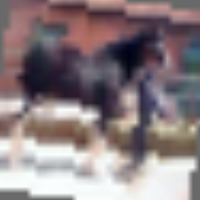

In [139]:
 -- display the random_number-th image in dataset
random_angle= -0.5+math.random(10000)/10000
random_idx = math.random(1000)

img = testset.data[random_idx] -- increase image size 
itorch.image(image.scale(image.rotate(rot_img, img, random_angle, simple),200))
-- -- your code here

Re-write the same neural network but adding data augmentation (horizontal flip and rotation)
Hint: Use lines 21-43 of https://github.com/szagoruyko/cifar.torch/blob/master/train.lua

In [148]:
do -- data augmentation module
  local BatchFlip,parent = torch.class('nn.BatchFlip', 'nn.Module')

  function BatchFlip:__init()
    parent.__init(self)
    self.train = true
  end

  function BatchFlip:updateOutput(input)
    if self.train then
      local bs = input:size(1)
      local flip_mask = torch.randperm(bs):le(bs/2)
      for i=1,input:size(1) do
        local random_angle = -0.5+math.random(10000)/10000
        image.rotate(input[i], input[i], random_angle, simple)
        if flip_mask[i] == 1 then image.hflip(input[i], input[i]) end
      end
    end
    self.output = input
    return self.output
    end
  
-- your code here

/home/mostafa/torch/install/share/lua/5.1/torch/init.lua:75: class nn.BatchFlip has been already assigned a parent class

stack traceback:
	[C]: in function 'newmetatable'
	/home/mostafa/torch/install/share/lua/5.1/torch/init.lua:75: in function 'class'
	[string "do -- data augmentation module..."]:2: in main chunk
	[C]: in function 'xpcall'
	/home/mostafa/torch/install/share/lua/5.1/itorch/main.lua:179: in function </home/mostafa/torch/install/share/lua/5.1/itorch/main.lua:143>
	/home/mostafa/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	...e/mostafa/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	...e/mostafa/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	...e/mostafa/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/home/mostafa/torch/install/share/lua/5.1/itorch/main.lua:350: in main chunk
	[C]: in function 'require'
	[string "arg={'/home/mostafa/.ipython/profile_default/..."]:1: in main chunk: 

In [ ]:
net = nn.Sequential()
net:add(nn.BatchFlip():float())
net:add(nn.SpatialConvolution(3, 20, 5, 5)) -- 1 input image channel, 6 output channels, 5x5 convolution kernel
net:add(nn.Dropout(0.3))
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.Dropout(0.3))
net:add(nn.View(20*14*14))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(20*14*14, 10))             -- fully connected layer (matrix multiplication between input and weights )                -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                


In [151]:
criterion = nn.ClassNLLCriterion()
trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.0001
trainer.maxIteration = 10

In [ ]:
trainer:train(trainset)

Let's look at the performance on the test set:

In [ ]:
print(criterion:forward(net:forward(testset.data:narrow(1, 1, 500)),testset.label:narrow(1, 1, 500)))

###Question: did you notice an improvement?

(your answer here)